In [1]:
import pandas as pd
import numpy as np

import random
import sys
import operator

from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
from matplotlib import animation, rc
from IPython.display import HTML
%matplotlib inline

from sklearn.neighbors import KDTree
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import pairwise_distances

In [2]:
class KMeans:
    def __init__(self, n_clusters, max_eps = 1., verbose=False):
        self.n = n_clusters
        self.max_eps = max_eps
        self.verbose = verbose
        
    def fit(self, data):
        self.X = np.array(data)
        self._calculate_clusters()
    
    def _calculate_clusters(self):
        self._labels = np.zeros((self.X.shape[0]))
        self._init_centroids()
        
        prev_eps = sys.float_info.max
        while True:
            eps = self._update()
            if self.verbose:
                print 'eps = {}, eps diff = {}'.format(eps, abs(prev_eps - eps))
            if abs(prev_eps - eps) < self.max_eps:
                break
            else:
                prev_eps = eps
                
    def _update(self):
        eps = 0.
        move = np.zeros((self.n, self.X.shape[1]))
        for obj_idx, obj in enumerate(self.X):          
            dist = [self._distance(obj, c) for c in self._centroids]
            min_index, min_value = min(enumerate(dist), key=operator.itemgetter(1))
            self._labels[obj_idx] = min_index
            move[min_index] += obj - self._centroids[min_index]
            eps += min_value
            
        move /= self.X.shape[0]
        self._centroids += move
        return eps
    
    @staticmethod
    def _distance(x, y):
        return np.linalg.norm(x - y)
        
    def _init_centroids(self):
        self._centroids = np.array(random.sample(self.X, self.n))
        
    def labels(self):
        return self._labels

In [3]:
def plot_kmeans(X, k_range, colors, eps = 1e-5, verbose=False):
    for k in k_range:
        model = KMeans(k, max_eps=eps, verbose=verbose)
        model.fit(X) 
        
        classes = range(k)
        labels = model.labels()
        plt.figure(figsize=(10, 7))
        for color, cluster in zip(colors[:k], classes):
            plt.scatter(X[labels == cluster][:,0], X[labels == cluster][:,1], color=color, s=15)
            plt.scatter(model._centroids[cluster][0], model._centroids[cluster][1], color=color, marker='X', s=250, lw=3, edgecolors='black')
        plt.title('k = {}'.format(k))

In [4]:
X = pd.read_csv('data/blobs.csv').as_matrix()

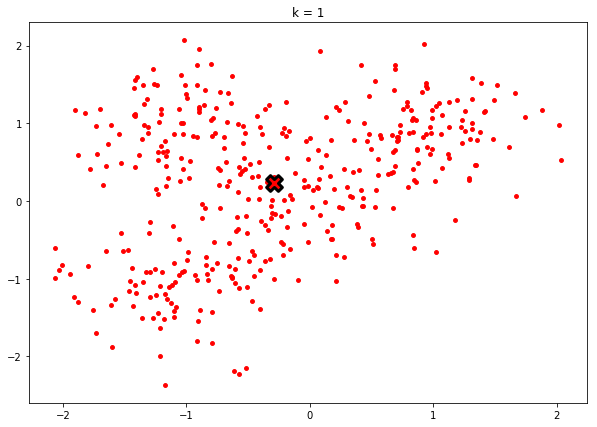

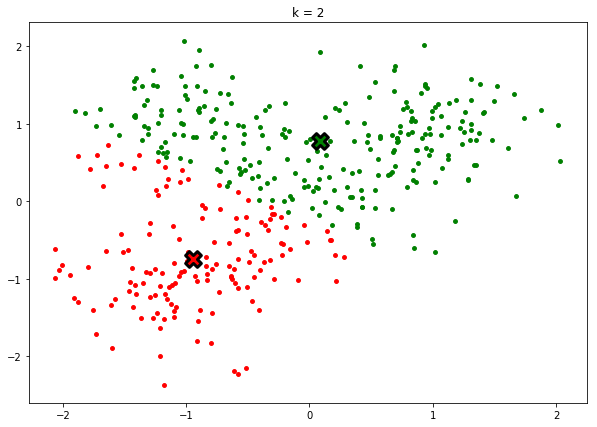

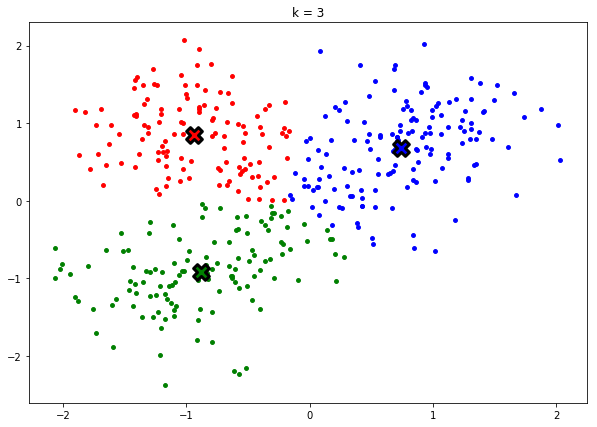

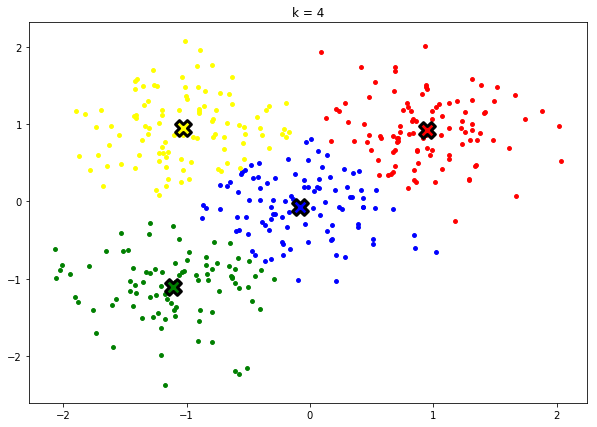

In [5]:
plot_kmeans(X, [1,2,3,4], colors=['red', 'green', 'blue', 'yellow'])

In [6]:
NOISE = -1

class DBScan:      
    def __init__(self, eps, min_cluster_size=10):
        self.eps = eps
        self.min_size = min_cluster_size
    
    def fit(self, data):
        self.X = np.copy(data)
        self.tree = KDTree(X)
        
        self._find_clusters()
        
        if np.sum(self._labels == NOISE) == self.X.shape[0]:
            self.cluster_count = self.X.shape[0]
        
    def _find_clusters(self):
        self.cluster_count = 0
        self._labels = np.full((self.X.shape[0]), NOISE, dtype=int)
        self._visited = np.full((self.X.shape[0]), False, dtype=bool)
        
        for idx, point in enumerate(self.X):
            if self._visited[idx]:
                continue
            self._visited[idx] = True
            neighbors = list(self.tree.query_radius([point], self.eps)[0])
            if len(neighbors) < self.min_size:
                self._labels[idx] = NOISE
            else:
                self._expand_cluster(idx, neighbors)
                self.cluster_count += 1
    
    @staticmethod
    def _join(dest, src):
        for v in src:
            if v not in dest:
                dest.append(v)

    def _expand_cluster(self, idx, neighbors):
        self._labels[idx] = self.cluster_count
        
        for n_idx in neighbors:
            if not self._visited[n_idx]:
                self._visited[n_idx] = True
                neighbor_pts = self.tree.query_radius([self.X[n_idx]], self.eps)[0]
                if len(neighbor_pts) >= self.min_size:
                    self._join(neighbors, neighbor_pts)           
            
            if self._labels[n_idx] == NOISE:
                self._labels[n_idx] = self.cluster_count
            
                                
    def labels(self):
        return self._labels

In [7]:
def find_radius(X, l, r, clusters, cluster_size=10):
    l = float(l)
    r = float(r)
    
    while True:
        m = l + (r-l)/2
        model = DBScan(m, min_cluster_size=cluster_size)
        model.fit(X)
        
        if model.cluster_count == clusters:
            return m
        
        if model.cluster_count < clusters:
            r = m
        else:
            l = m

In [8]:
def plot_dbcluster(X, eps_values):
    for eps in eps_values:
        model = DBScan(eps, min_cluster_size=10)
        model.fit(X) 
        
        classes = range(model.cluster_count)
        labels = model.labels()
        plt.figure(figsize=(10, 7))
        for color, cluster in zip(mcolors.cnames.keys(), classes):
            plt.scatter(X[labels == cluster][:,0], X[labels == cluster][:,1], color=color, s=15)
        plt.scatter(X[labels == NOISE][:,0], X[labels == NOISE][:,1], color='gray', s=15)
        plt.title('eps = {}, cluster count = {}'.format(eps, model.cluster_count))

In [9]:
from sklearn.cluster import DBSCAN

def check_with_scikit(X, eps, clusters):
        model = DBScan(eps, min_cluster_size=10)
        model.fit(X) 
        labels_custom = model.labels()
        
        model = DBSCAN(eps=eps, min_samples=10)
        model.fit(X)
        labels_scikit = model.labels_
           
        print np.all(labels_custom == labels_scikit)

In [10]:
optimal_eps = find_radius(X, 0, 1, 4)
print optimal_eps

0.2373046875


In [11]:
check_with_scikit(X, optimal_eps, 4)

True


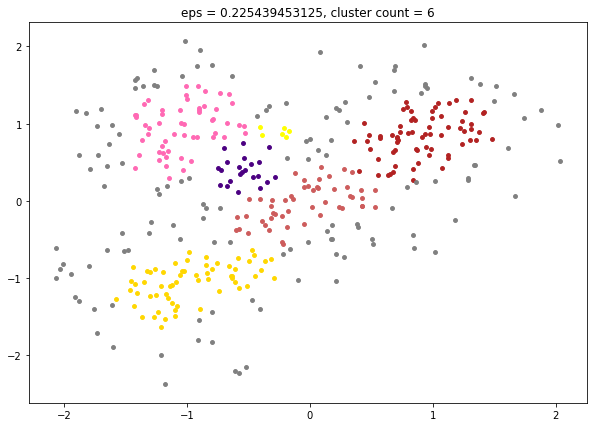

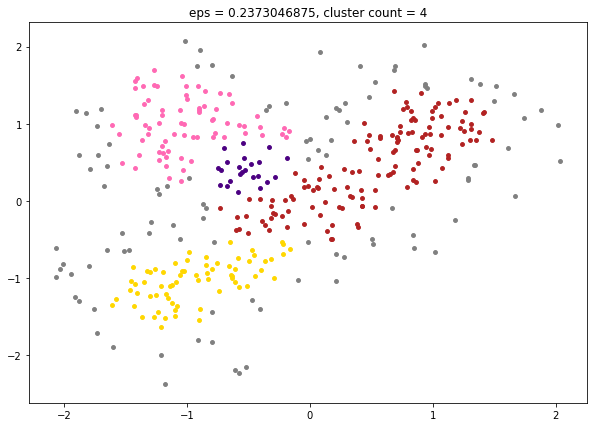

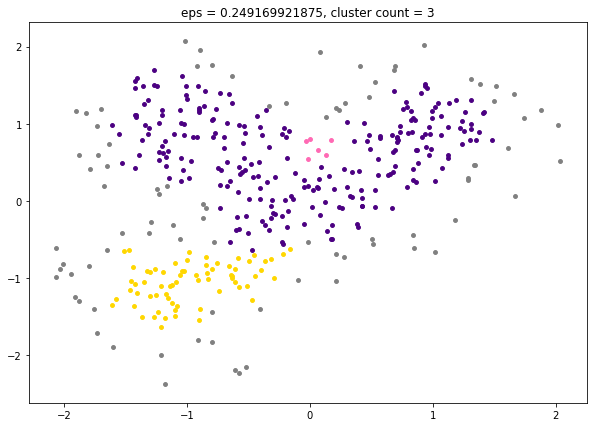

In [12]:
plot_dbcluster(X, [optimal_eps*0.95, optimal_eps, optimal_eps*1.05])

In [13]:
# https://habrahabr.ru/post/321216/
class AffinityPropagation:
    def __init__(self, metric = 'euclidean', max_iter = 100, damping = 0.5, batch_size = 15, self_distance=0.):
        self.max_iter = max_iter
        self.damping = damping
        self.batch_size = batch_size
        self.metric = metric
        self.self_distance = 0.
    
    def fit(self, X):
        self.X = np.array(X)
        self._precalc_distance()
        self._find_clusters()
   
    
    def _precalc_distance(self):
        self._S = -1*pairwise_distances(X, metric=self.metric)
        np.fill_diagonal(self._S, -self.self_distance)

    
    def _calc_AR_matrices(self, A, R, idx):
        n_samples = A.shape[0]
        tmp = np.zeros((n_samples, n_samples))
        #             tmp = A + S
        np.add(A, self._S, tmp) #too much memory with temporary object
        I = np.argmax(tmp, axis=1)
        Y = tmp[idx, I]
        tmp[idx, I] = -np.inf
        Y2 = np.max(tmp, axis=1)

#             tmp = S - Y[:, None]
        np.subtract(self._S, Y[:, None], tmp)
        tmp[idx, I] = self._S[idx, I] - Y2

        tmp *= 1 - self.damping
        R *= self.damping
        R += tmp

        np.maximum(R, 0, tmp)
        tmp.flat[::n_samples + 1] = R.flat[::n_samples + 1]

        tmp -= np.sum(tmp, axis=0)
        dA = np.diag(tmp).copy()
        tmp.clip(0, np.inf, tmp)
        tmp.flat[::n_samples + 1] = dA

        tmp *= 1 - self.damping
        A *= self.damping
        A -= tmp
    
    
    def _find_clusters(self):            
        n_samples = self._S.shape[0]

        preference = np.median(self._S)
        self._S.flat[::(n_samples + 1)] = preference

        A = np.zeros((n_samples, n_samples))
        R = np.zeros((n_samples, n_samples)) 
        
        #adding noise
        self._S += np.random.randn(n_samples, n_samples)*1e-16
        e = np.zeros((n_samples, self.batch_size))

        idx = np.arange(n_samples)

        for i in range(self.max_iter):
            self._calc_AR_matrices(A, R, idx)
            E = (np.diag(A) + np.diag(R)) > 0
            e[:, i % self.batch_size] = E
            K = np.sum(E, axis=0)

            if i >= self.batch_size:
                se = np.sum(e, axis=1)
                converged = (np.sum((se == self.batch_size) + (se == 0)) == n_samples)
                if (converged and (K > 0)) or (i == self.max_iter):
                    break

        I = np.where(np.diag(A + R) > 0)[0]
        class_counts = I.size

        if class_counts > 0:
            c = np.argmax(self._S[:, I], axis=1)
            c[I] = np.arange(class_counts)
            for k in range(class_counts):
                ii = np.where(c == k)[0]
                j = np.argmax(np.sum(self._S[ii[:, np.newaxis], ii], axis=0))
                I[k] = ii[j]

            c = np.argmax(self._S[:, I], axis=1)
            c[I] = np.arange(class_counts)
            labels = I[c]
            clusters_centers = np.unique(labels)
            labels = np.searchsorted(clusters_centers, labels)
        else:
            labels = np.empty((n_samples, 1))
            clusters_centers = None
            labels.fill(np.nan)
        
        self._centroids = self.X[clusters_centers]
        self._labels = labels
        self._converged = converged
    
    def centroids(self):
        return self._centroids
    
    def labels(self):
        return self._labels

In [14]:
def plot_affinity(X, metrics):
    for m in metrics:
        model = AffinityPropagation(metric=m, self_distance=10.)
        model.fit(X)
        
        num_classes = len(model._centroids)
        classes = range(num_classes)
        labels = model.labels()
        plt.figure(figsize=(10, 7))
        for color, cluster in zip(mcolors.cnames.keys(), classes):
            plt.scatter(X[labels == cluster][:,0], X[labels == cluster][:,1], color=color, s=15)
            plt.scatter(model._centroids[cluster][0], model._centroids[cluster][1], color=color, marker='X', s=250, lw=3, edgecolors='black')
        plt.title('metric = {}, num classes = {}, converged = {} '.format(m, num_classes, model._converged))

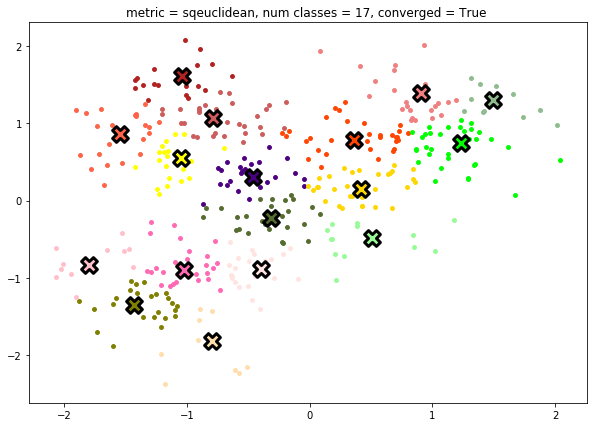

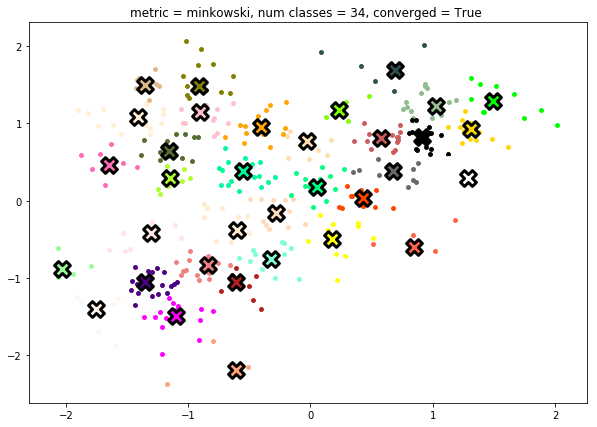

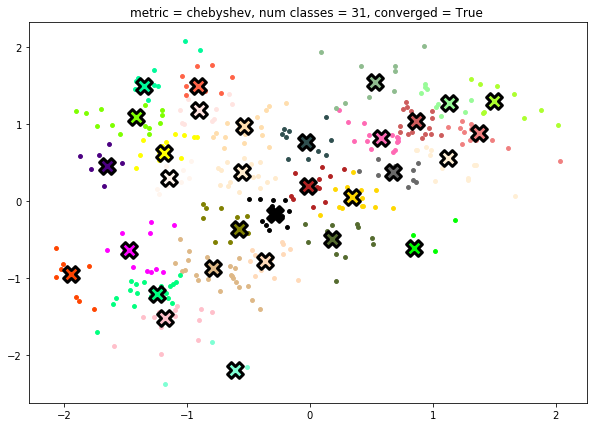

In [15]:
plot_affinity(X, metrics = ['sqeuclidean', 'minkowski', 'chebyshev'])

In [16]:
data = pd.read_csv('data/mnist.csv')
X = data.drop(['label'], axis=1)
y = data['label']

In [17]:
X_trans = PCA(n_components=2).fit(X).transform(X)

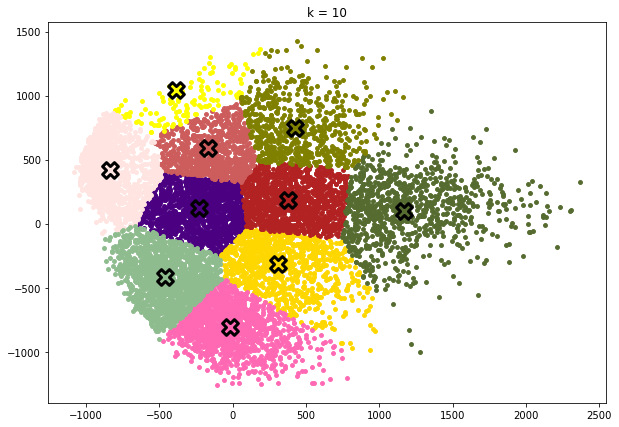

In [18]:
plot_kmeans(X_trans, [10], mcolors.cnames.keys(), eps=1000)